In [1]:
"""
Install virtual enviroment outside project folder.
In command line enter:
python3 -m venv multimodal
pip install ipykernel
python3 -m ipykernel install --user --name=multimodal
Start `Jupyter Lab` at /Multimodal-Deep-Regression/notebooks
Select `multimodal` kernel in right upper corner.
"""
!pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/isaacOnline/whisper.git (to revision extract-embeddings) to /tmp/pip-req-build-zql1yk3v
  Running command git clone --filter=blob:none --quiet https://github.com/isaacOnline/whisper.git /tmp/pip-req-build-zql1yk3v
  Running command git checkout -b extract-embeddings --track origin/extract-embeddings
  Switched to a new branch 'extract-embeddings'
  Branch 'extract-embeddings' set up to track remote branch 'extract-embeddings' from 'origin'.
  Resolved https://github.com/isaacOnline/whisper.git to commit 50e1e7361f45350d986a00c35d5b83a666384be7
  Preparing metadata (setup.py) ... done


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import random
import time
import whisper
import numpy
import warnings

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch, process_data, add_ae_tensor, get_ensemble_data, generate_batch_ensemble, generate_autoencoder_batch
from util.audio_utilities import extract_embeddings, extract_audio

In [3]:
# Preprocessing paramemter & ConvLSTMAutoencoder
DEVICE = 'cpu' #get_device() # CPU or GPU
DATASET = 'video_pack_20'
FRAME_SKIP = 200 # how many frame to skip, reduce depth
SHRINK = 8 # shrink the scale (H x W)//N
NORMALIZE = False # normalize the pixel to 0 to 1
PAD_ALL = False # pad all tensors with max depth
BATCH_SIZE = 2

In [4]:
# ConvLSTMAutoencoder Hyper-Parameters
LEARNING_RATE = 1e-4
EPOCHS = 10
HIDDEN_SIZE = 64 # ConvLSTMAutoencoder hidden size

In [5]:
# Transformer Visual & Audio Hyper-Parameters
NUM_HEADS = 8 # number of attenion heads
HIDDEN_DIM = 256 # Transformer hidden size
NUM_LAYERS = 6 # number of Transformer layers

# EnsembleModel Hyper-Parameters
LEARNING = 1e-3
THE_EPOCHS = 10
AUDIO_TRANSFORMER = True # if False, will skip audio transfomer part #NOT WORKING YET
LATE_FUSION = True # early fusion or late fusion #NOT WORKING YET

In [6]:
# extract audio from video dataset
extract_audio(f"../data/video_packs/{DATASET}/", f"../data/audio/{DATASET}")

# using whipser to transcribe audio dialog & extract LLMs embedding
extract_embeddings(audio_file_path=f"../data/audio/{DATASET}", output_dir="../data/audio_embeddings/")

Extract in audio from video pack to .wav format..


100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  9.53it/s]


Converting to audio files to embeddings..


100%|███████████████████████████████████████| 20/20 [00:00<00:00, 198312.25it/s]


In [7]:
# disable pyav warning
warnings.filterwarnings("ignore", message="Accurate seek is not implemented for pyav backend")

# video visual processing
process_data(
    input_type=DATASET, 
    #addition_parameters={'first_n_videos': 10}, 
    verbose=False,
    device=get_device(),
    frames_to_skip=FRAME_SKIP,
    shrink=SHRINK,
    normalize=NORMALIZE
    )

You are using device: cuda
Processing video visual to tensors..


100%|███████████████████████████████████████████| 20/20 [01:19<00:00,  4.00s/it]


In [8]:
x_dir, y_dir = get_base_tensor_directories(input_type=DATASET)

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)]) 
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

In [9]:
# load all visual tensors
x_data = [torch.load(f) for f in x_files] 
y_data = [torch.load(f) for f in y_files] 

# split the data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
print(x_train[0].size())
print(x_val[0].size())
print(len(y_train))
print(len(y_val))

torch.Size([3, 3, 128, 72])
torch.Size([3, 1, 128, 72])
16
4


In [10]:
# Create AutoEncoder Batches with DataLoaders
batch_size = BATCH_SIZE
train_loader = list(zip(x_train, x_train))
val_loader = list(zip(x_val, x_val))
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_autoencoder_batch)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_autoencoder_batch)

# check size Batch, Channel, Frame, Height, Width
data, targets = next(iter(train_loader))
data.size(), targets.size()

(torch.Size([2, 3, 5, 128, 72]), torch.Size([2, 3, 5, 128, 72]))

In [11]:
from models import ConvLSTMAutoencoder

autoencoder = ConvLSTMAutoencoder(hidden_dim=HIDDEN_SIZE, shrink=SHRINK, normalize=NORMALIZE)
autoencoder = autoencoder.to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 1,041,859


In [12]:
ECHO = 1 # print in N epoch only when training
SAVE_NAME = 'ConvLSTMAutoencoder_hidden6222_weights.pt' # save the weights
autoencoder_load = False

In [13]:
start_time = time.time()

if not autoencoder_load:
    train_losses = []
    val_losses = []

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(autoencoder, train_loader, criterion, optimizer, DEVICE)
    val_loss, avg_val_loss = evaluate(autoencoder, val_loader, criterion, DEVICE)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    echo = ECHO
    if ((epoch+1) % echo == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')

First epoch took 0.7 minutes.
Epoch 1/10, Train_Loss: 67081.09, Avg: 8385.14; Val_Loss: 22226.83, Avg: 11113.42
Epoch 2/10, Train_Loss: 64824.87, Avg: 8103.11; Val_Loss: 20412.23, Avg: 10206.11
Epoch 3/10, Train_Loss: 56980.36, Avg: 7122.55; Val_Loss: 12961.67, Avg: 6480.83
Epoch 4/10, Train_Loss: 42472.68, Avg: 5309.09; Val_Loss: 9400.97, Avg: 4700.48
Epoch 5/10, Train_Loss: 31867.74, Avg: 3983.47; Val_Loss: 8057.28, Avg: 4028.64
Epoch 6/10, Train_Loss: 32242.44, Avg: 4030.30; Val_Loss: 8124.67, Avg: 4062.34
Epoch 7/10, Train_Loss: 31227.27, Avg: 3903.41; Val_Loss: 7004.57, Avg: 3502.29
Epoch 8/10, Train_Loss: 26927.03, Avg: 3365.88; Val_Loss: 6909.49, Avg: 3454.75
Epoch 9/10, Train_Loss: 24642.47, Avg: 3080.31; Val_Loss: 6817.46, Avg: 3408.73
Epoch 10/10, Train_Loss: 25949.60, Avg: 3243.70; Val_Loss: 6469.94, Avg: 3234.97


In [14]:
if not autoencoder_load:
    # save model if better or not exists
    model_weights = {'model_state_dict': autoencoder.state_dict(), 'val_loss': avg_train_loss, 'train_losses':train_losses, 'val_losses':val_losses}
    weights_file = f'../models/save/{SAVE_NAME}'
    if not os.path.isfile(weights_file):
        # save new
        torch.save(model_weights, weights_file)
        print('save new model')
    elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
        # replace
        torch.save(model_weights, weights_file)
        print('replace old model')
    else:
        print('old model perform better')

save new model


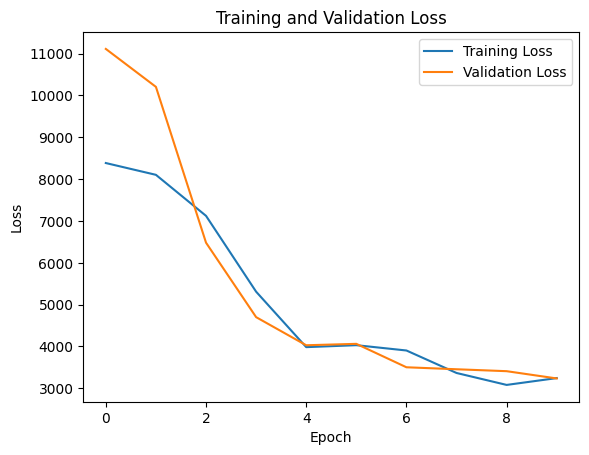

In [15]:
# loss plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Actual:
torch.Size([3, 128, 72])


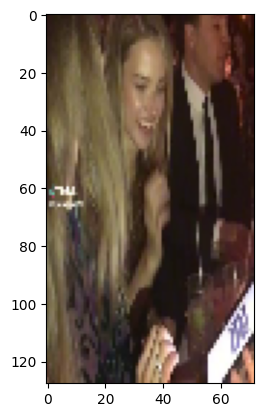

torch.Size([3, 128, 72])


/tmp/ipykernel_439646/997935038.py:23: RuntimeWarning: invalid value encountered in divide
  numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())
/home/louis/Documents/gatech/Summer2023/whisperenv/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


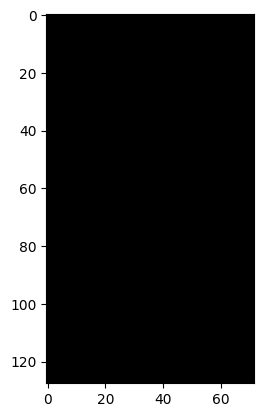

torch.Size([3, 128, 72])


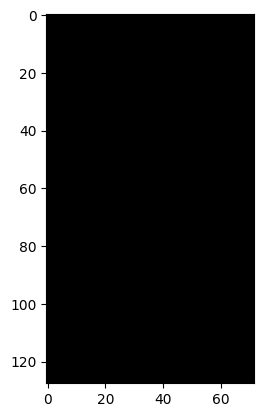

AutoEncoder:


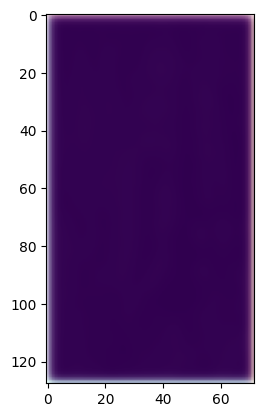

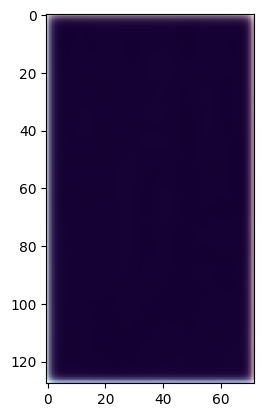

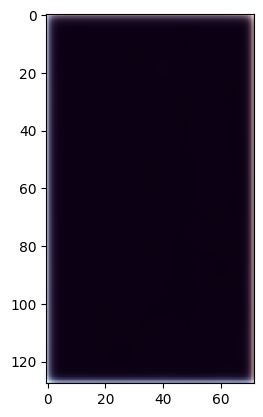

In [16]:
# Random sample inspection
random_num = random.randint(0, len(val_loader)-1)

for i, (inputs, targets) in enumerate(val_loader):
    if i == random_num:  # random sample
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        outputs = autoencoder(inputs).detach()
        break

        
# Actual
print('Actual:')
for i in range(3):
    # select first 3 frame
    image_tensor = targets.squeeze()[0,:,i,:,:]
    print(image_tensor.size())
    numpy_image = image_tensor.detach().numpy()

    # imshow (Height, Width, Channels)
    numpy_image = numpy_image.transpose((1, 2, 0))

    # normalize to 0,1
    numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())

    plt.imshow(numpy_image)
    plt.show()
    
# AutoEncoder
print('AutoEncoder:')
for i in range(3):
    # select first 3 frame
    image_tensor = outputs.squeeze()[0,:,i,:,:]
    numpy_image = image_tensor.detach().numpy()

    # imshow (Height, Width, Channels)
    numpy_image = numpy_image.transpose((1, 2, 0))

    # normalize to 0,1
    numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())

    plt.imshow(numpy_image)
    plt.show()

In [17]:
# load ensemble data
x_data, y_data = get_ensemble_data(x_files, DATASET)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

train_loader = list(zip(x_train, y_train))
val_loader = list(zip(x_val, y_val))
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_batch_ensemble)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_batch_ensemble)

print(f'Train set size: {len(x_train)}')
print(f'Val set size: {len(x_val)}')

Train set size: 16
Val set size: 4


In [18]:
from models import TransformerModel_Visual, TransformerModel_Audio, EnsembleModel

model1 = TransformerModel_Visual(
d_model = 9216,
nhead = NUM_HEADS,
d_hid = HIDDEN_DIM,
nlayers = NUM_LAYERS
)

if AUDIO_TRANSFORMER:
    model2 = TransformerModel_Audio(
        d_model = 512,
        nhead = NUM_HEADS,
        d_hid = HIDDEN_DIM ,
        nlayers = NUM_LAYERS
    )
else:
    model2 = TransformerModel_Audio(
        d_model = 512,
        nhead = NUM_HEADS,
        d_hid = HIDDEN_DIM ,
        nlayers = NUM_LAYERS,
        pass_transformer=True
    )

ensemble_model = EnsembleModel(model1,model2)
total_params = sum(p.numel() for p in ensemble_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 2,227,312,129


In [19]:
# Training
def ensemble_train(ensemble_model, autoencoder, dataloader, criterion, optimizer, device='cpu', verbose=False):
    ensemble_model.train()
    total_loss = 0.0
    for visuals, audio_embeds, targets in dataloader:
        visuals, audio_embeds, targets = visuals.to(device), audio_embeds.to(device), targets.to(device)
        visual_embeds = autoencoder.getembedding(visuals).detach()
        outputs = ensemble_model.forward(visual_embeds, audio_embeds)
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        return total_loss, avg_loss

# Evaluate
def ensemble_evaluate(ensemble_model, autoencoder, dataloader, criterion, device='cpu', verbose=False):
    ensemble_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for visuals, audio_embeds, targets in dataloader:
            visuals, audio_embeds, targets = visuals.to(device), audio_embeds.to(device), targets.to(device)
            visual_embeds = autoencoder.getembedding(visuals).detach()
            outputs = ensemble_model.forward(visual_embeds, audio_embeds)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            avg_loss = total_loss / len(dataloader)
            return total_loss, avg_loss

In [20]:
ECHO = 1  # print in N epoch only when training
SAVE_NAME = 'EnsembleModel_hidden51222_weights.pt'  # save the weights
ensemble_model_load = False

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(ensemble_model.parameters(),lr=LEARNING)

EPOCHS = THE_EPOCHS
start_time = time.time()

if not ensemble_model_load:
    train_losses = []
    val_losses = []

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = ensemble_train(ensemble_model, autoencoder, train_loader, criterion, optimizer, DEVICE)
    val_loss, avg_val_loss = ensemble_evaluate(ensemble_model, autoencoder, val_loader, criterion, DEVICE)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = ECHO
    if ((epoch+1) % ECHO == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')

First epoch took 0.3 minutes.
Epoch 1/10, Train_Loss: 161166528.00000, Avg: 20145816.00000; Val_Loss: 49354.89844, Avg: 24677.44922
Epoch 2/10, Train_Loss: 157132160.00000, Avg: 19641520.00000; Val_Loss: 5413700.00000, Avg: 2706850.00000
Epoch 3/10, Train_Loss: 129107792.00000, Avg: 16138474.00000; Val_Loss: 28732148.00000, Avg: 14366074.00000
Epoch 4/10, Train_Loss: 96511504.00000, Avg: 12063938.00000; Val_Loss: 117246440.00000, Avg: 58623220.00000
Epoch 5/10, Train_Loss: 54487468.00000, Avg: 6810933.50000; Val_Loss: 288643392.00000, Avg: 144321696.00000
Epoch 6/10, Train_Loss: 39553724.00000, Avg: 4944215.50000; Val_Loss: 375453888.00000, Avg: 187726944.00000
Epoch 7/10, Train_Loss: 41339544.00000, Avg: 5167443.00000; Val_Loss: 367405824.00000, Avg: 183702912.00000
Epoch 8/10, Train_Loss: 39047832.00000, Avg: 4880979.00000; Val_Loss: 335911488.00000, Avg: 167955744.00000
Epoch 9/10, Train_Loss: 38654860.00000, Avg: 4831857.50000; Val_Loss: 339795392.00000, Avg: 169897696.00000
Epoch 

In [22]:
if not ensemble_model_load:
    # save model if better or not exists
    model_weights = {'model_state_dict': ensemble_model.state_dict(), 'val_loss': avg_train_loss, 'train_losses':train_losses, 'val_losses':val_losses}
    weights_file = f'../models/save/{SAVE_NAME}'
    if not os.path.isfile(weights_file):
        # save new
        torch.save(model_weights, weights_file)
        print('save new model')
    elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
        # replace
        torch.save(model_weights, weights_file)
        print('replace old model')
    else:
        print('old model perform better')

save new model


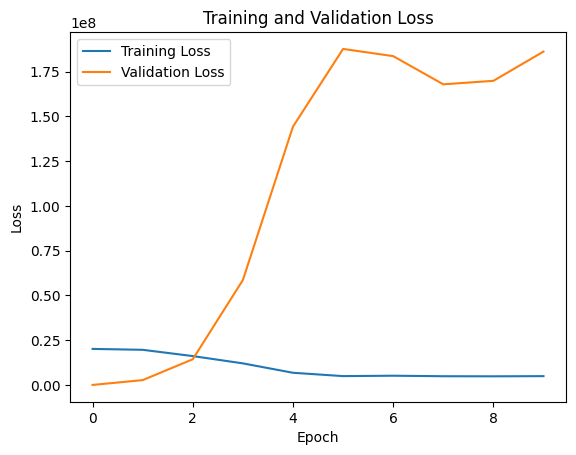

In [23]:
# loss plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

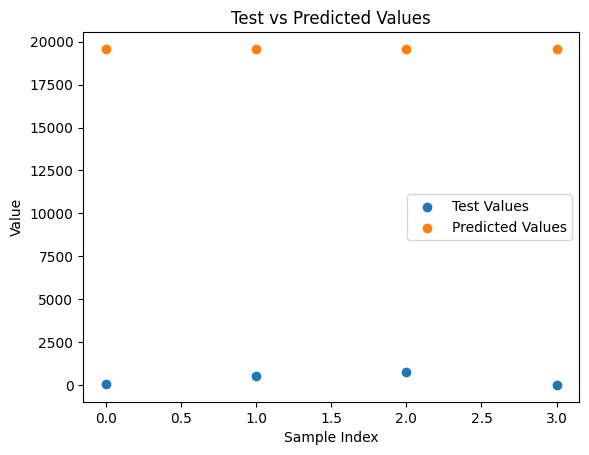

In [24]:
# compare to validation set
val_values = []
predicted_values = []
    
for visuals, audio_embeds, targets in val_loader:
    visuals, audio_embeds, targets = visuals.to(DEVICE), audio_embeds.to(DEVICE), targets.to(DEVICE)
    visual_embeds = autoencoder.getembedding(visuals).detach()
    outputs = ensemble_model.forward(visual_embeds, audio_embeds).detach()
    # Append the values
    val_values.extend(targets.squeeze().tolist())
    predicted_values.extend(outputs.squeeze().tolist())
    
plt.scatter(range(len(val_values)), val_values, label='Test Values')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [25]:
# Inspect first N
N = 10
val_check = [round(i, 2) for i in val_values][:N]
predicted_check = [round(i, 2) for i in predicted_values][:N]
print('Val', val_check)
print('Predict', predicted_check)

Val [58.5, 502.4, 745.1, 0.0]
Predict [19579.08, 19579.09, 19579.05, 19579.07]


In [27]:
# get MSE for the vaildation set
mse = mean_squared_error(val_values, predicted_values)
print(f'MSE: {mse:.2f}, Lenght: {len(val_values)}')

MSE: 370757747.32, Lenght: 4
